<a href="https://colab.research.google.com/github/RasvanthKC/Qiskit_Bernstein_Vazirani/blob/main/bv_bernstein_vazirani_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bernstein–Vazirani Algorithm (Qiskit 2.x)

This notebook walks through the Bernstein–Vazirani (BV) algorithm using the base code we had.
We will:
1. Recall the base BV circuit.
2. Run it on a secret string and verify the output.
3. Add a constant bit **b** to the oracle and see how it affects the ancilla.
4. Add noise using `qiskit_aer.noise.NoiseModel` to see robustness.

> **Idea:** BV finds a hidden string `s` from an oracle that computes `f(x) = s · x (mod 2)` in **one** query, thanks to quantum superposition and interference.

## 1. Imports and setup
We import Qiskit core, Aer simulator, and visualization tools.

In [12]:
!pip install qiskit qiskit-aer matplotlib
!pip install pylatexenc


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


## 2. Base BV Oracle and Circuit
This is exactly the base code: oracle for `f(x) = s · x`, then Hadamard → oracle → Hadamard → measure.

In [5]:
def bv_oracle(qc, inputs, ancilla, s):
    """Implements oracle for f(x) = s · x (no constant b)."""
    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(inputs[i], ancilla)

def bernstein_vazirani_circuit(s):
    n = len(s)
    qreg = QuantumRegister(n + 1, 'q')
    creg = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qreg, creg)
    inputs = list(range(n))
    ancilla = n

    # prepare ancilla in |1>
    qc.x(ancilla)
    # put all qubits in superposition
    qc.h(qreg)
    # oracle call
    bv_oracle(qc, inputs, ancilla, s)
    # uncompute via Hadamard on input qubits
    for q in inputs:
        qc.h(q)
    # measure input register
    qc.measure(inputs, creg)
    return qc


## 3. Helper to run and visualize
This runs on Aer and shows the histogram so we can visually confirm the secret string.

In [6]:
def run_bv(qc, shots=1024):
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    display(plot_histogram(counts))
    most = max(counts, key=counts.get)
    print('Counts:', counts)
    print('Most frequent measured bitstring (input register):', most)
    return counts, most


## 4. Task 1: Change secret string `s` and verify output
We try several `s` values and see that the measurement matches.


--- Testing s = 1011 ---
(fallback to text circuit, drawer not available):
     ┌───┐          ┌───┐          ┌─┐           
q_0: ┤ H ├───────■──┤ H ├──────────┤M├───────────
     ├───┤┌───┐  │  └┬─┬┘          └╥┘           
q_1: ┤ H ├┤ H ├──┼───┤M├────────────╫────────────
     ├───┤└───┘  │   └╥┘      ┌───┐ ║      ┌─┐   
q_2: ┤ H ├───────┼────╫────■──┤ H ├─╫──────┤M├───
     ├───┤       │    ║    │  └───┘ ║ ┌───┐└╥┘┌─┐
q_3: ┤ H ├───────┼────╫────┼────■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐  ║  ┌─┴─┐┌─┴─┐ ║ └───┘ ║ └╥┘
q_4: ┤ X ├┤ H ├┤ X ├──╫──┤ X ├┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘  ║  └───┘└───┘ ║       ║  ║ 
c: 4/═════════════════╩═════════════╩═══════╩══╩═
                      1             0       2  3 
Drawer error was: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."


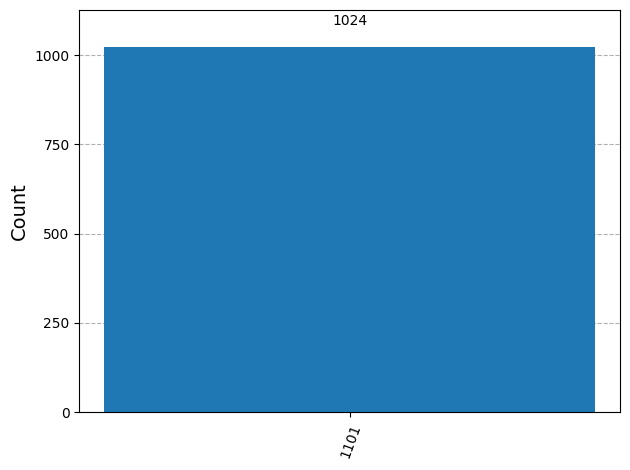

Counts: {'1101': 1024}
Most frequent measured bitstring (input register): 1101
⚠️ Did not recover 1011

--- Testing s = 0000 ---
(fallback to text circuit, drawer not available):
     ┌───┐┌───┐┌─┐         
q_0: ┤ H ├┤ H ├┤M├─────────
     ├───┤├───┤└╥┘┌─┐      
q_1: ┤ H ├┤ H ├─╫─┤M├──────
     ├───┤├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├┤ H ├─╫──╫─┤M├───
     ├───┤├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├┤ H ├─╫──╫──╫─┤M├
     ├───┤├───┤ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├─╫──╫──╫──╫─
     └───┘└───┘ ║  ║  ║  ║ 
c: 4/═══════════╩══╩══╩══╩═
                0  1  2  3 
Drawer error was: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."


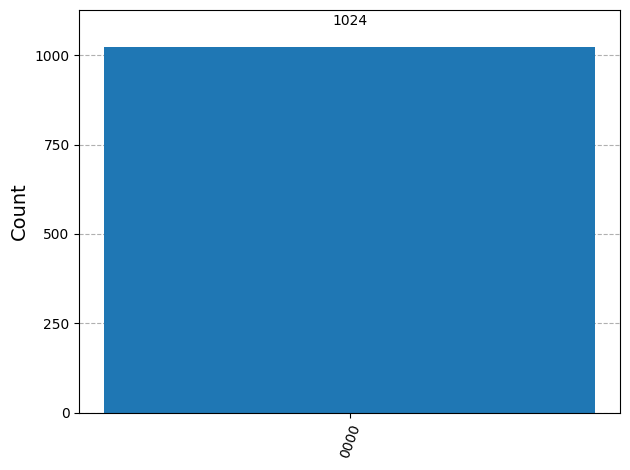

Counts: {'0000': 1024}
Most frequent measured bitstring (input register): 0000
✅ Recovered 0000

--- Testing s = 1111 ---
(fallback to text circuit, drawer not available):
     ┌───┐          ┌───┐     ┌─┐                   
q_0: ┤ H ├───────■──┤ H ├─────┤M├───────────────────
     ├───┤       │  └───┘┌───┐└╥┘     ┌─┐           
q_1: ┤ H ├───────┼────■──┤ H ├─╫──────┤M├───────────
     ├───┤       │    │  └───┘ ║ ┌───┐└╥┘     ┌─┐   
q_2: ┤ H ├───────┼────┼────■───╫─┤ H ├─╫──────┤M├───
     ├───┤       │    │    │   ║ └───┘ ║ ┌───┐└╥┘┌─┐
q_3: ┤ H ├───────┼────┼────┼───╫───■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐┌─┴─┐┌─┴─┐ ║ ┌─┴─┐ ║ └───┘ ║ └╥┘
q_4: ┤ X ├┤ H ├┤ X ├┤ X ├┤ X ├─╫─┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘└───┘└───┘ ║ └───┘ ║       ║  ║ 
c: 4/══════════════════════════╩═══════╩═══════╩══╩═
                               0       1       2  3 
Drawer error was: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."


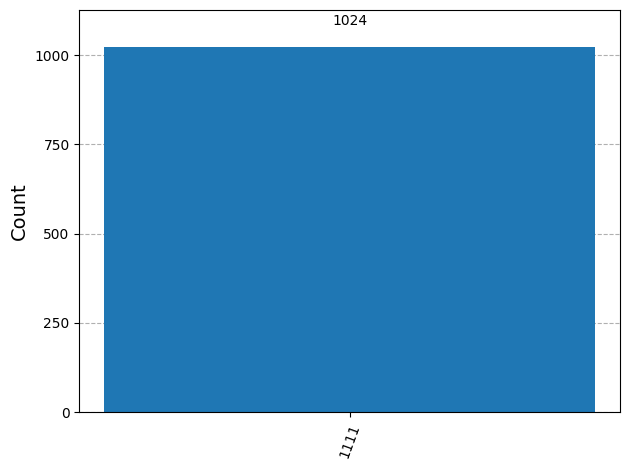

Counts: {'1111': 1024}
Most frequent measured bitstring (input register): 1111
✅ Recovered 1111

--- Testing s = 0101 ---
(fallback to text circuit, drawer not available):
     ┌───┐┌───┐     ┌─┐                     
q_0: ┤ H ├┤ H ├─────┤M├─────────────────────
     ├───┤└───┘     └╥┘┌───┐          ┌─┐   
q_1: ┤ H ├───────■───╫─┤ H ├──────────┤M├───
     ├───┤┌───┐  │   ║ └┬─┬┘          └╥┘   
q_2: ┤ H ├┤ H ├──┼───╫──┤M├────────────╫────
     ├───┤└───┘  │   ║  └╥┘      ┌───┐ ║ ┌─┐
q_3: ┤ H ├───────┼───╫───╫────■──┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐ ║   ║  ┌─┴─┐└───┘ ║ └╥┘
q_4: ┤ X ├┤ H ├┤ X ├─╫───╫──┤ X ├──────╫──╫─
     └───┘└───┘└───┘ ║   ║  └───┘      ║  ║ 
c: 4/════════════════╩═══╩═════════════╩══╩═
                     0   2             1  3 
Drawer error was: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."


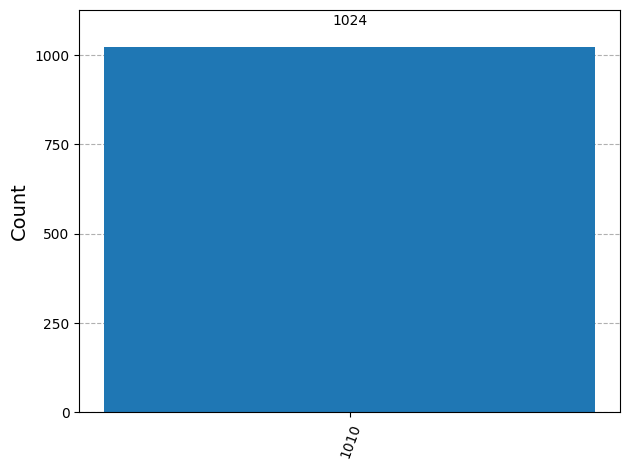

Counts: {'1010': 1024}
Most frequent measured bitstring (input register): 1010
⚠️ Did not recover 0101

--- Testing s = 1000 ---
(fallback to text circuit, drawer not available):
     ┌───┐          ┌───┐      ┌─┐
q_0: ┤ H ├───────■──┤ H ├──────┤M├
     ├───┤┌───┐  │  └┬─┬┘      └╥┘
q_1: ┤ H ├┤ H ├──┼───┤M├────────╫─
     ├───┤├───┤  │   └╥┘ ┌─┐    ║ 
q_2: ┤ H ├┤ H ├──┼────╫──┤M├────╫─
     ├───┤├───┤  │    ║  └╥┘┌─┐ ║ 
q_3: ┤ H ├┤ H ├──┼────╫───╫─┤M├─╫─
     ├───┤├───┤┌─┴─┐  ║   ║ └╥┘ ║ 
q_4: ┤ X ├┤ H ├┤ X ├──╫───╫──╫──╫─
     └───┘└───┘└───┘  ║   ║  ║  ║ 
c: 4/═════════════════╩═══╩══╩══╩═
                      1   2  3  0 
Drawer error was: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."


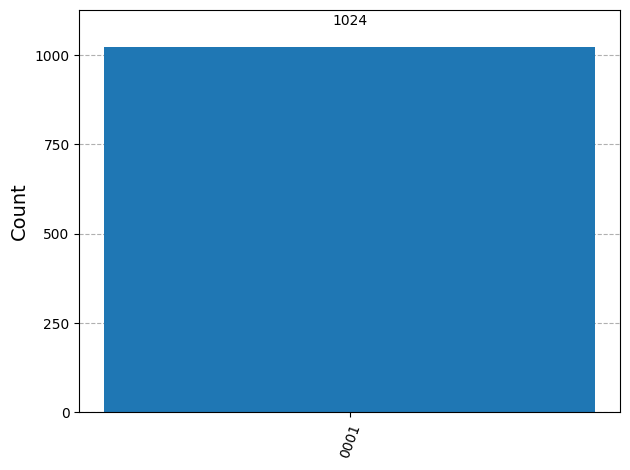

Counts: {'0001': 1024}
Most frequent measured bitstring (input register): 0001
⚠️ Did not recover 1000


In [14]:
secret_strings = ["1011", "0000", "1111", "0101", "1000"]

for s in secret_strings:
    print(f"\n--- Testing s = {s} ---")
    qc = bernstein_vazirani_circuit(s)
    # try pretty circuit first
    try:
        display(qc.draw(output="mpl", fold=-1))
    except Exception as e:
        # fallback to text so the loop continues
        print("(fallback to text circuit, drawer not available):")
        print(qc.draw(output="text", fold=-1))
        print("Drawer error was:", e)

    counts, measured = run_bv(qc)
    if measured == s:
        print("✅ Recovered", s)
    else:
        print("⚠️ Did not recover", s)


## 5. Task 2: Oracle with constant bit b
Now we upgrade the oracle to compute `f(x) = s · x ⊕ b`. The constant bit should **only affect the ancilla**, not the recovered input string.


--- s='1011', b=0 ---
(fallback to text circuit)
     ┌───┐          ┌───┐          ┌─┐           
q_0: ┤ H ├───────■──┤ H ├──────────┤M├───────────
     ├───┤┌───┐  │  └┬─┬┘          └╥┘           
q_1: ┤ H ├┤ H ├──┼───┤M├────────────╫────────────
     ├───┤└───┘  │   └╥┘      ┌───┐ ║      ┌─┐   
q_2: ┤ H ├───────┼────╫────■──┤ H ├─╫──────┤M├───
     ├───┤       │    ║    │  └───┘ ║ ┌───┐└╥┘┌─┐
q_3: ┤ H ├───────┼────╫────┼────■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐  ║  ┌─┴─┐┌─┴─┐ ║ └───┘ ║ └╥┘
q_4: ┤ X ├┤ H ├┤ X ├──╫──┤ X ├┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘  ║  └───┘└───┘ ║       ║  ║ 
c: 4/═════════════════╩═════════════╩═══════╩══╩═
                      1             0       2  3 


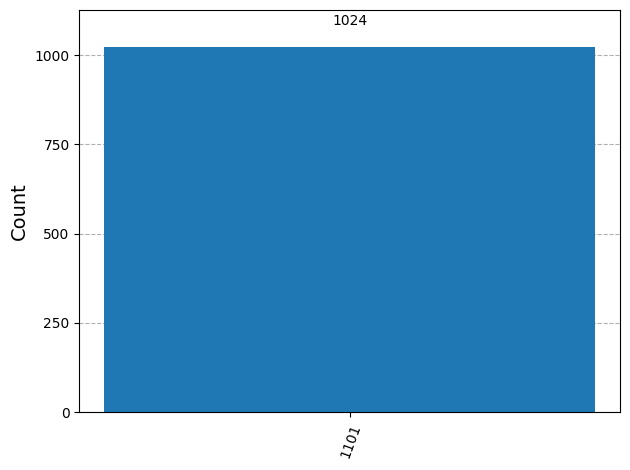

Counts: {'1101': 1024}
Most frequent measured bitstring (input register): 1101
Measured: 1101

--- s='1011', b=1 ---
(fallback to text circuit)
     ┌───┐                  ┌───┐     ┌─┐           
q_0: ┤ H ├───────────────■──┤ H ├─────┤M├───────────
     ├───┤┌───┐     ┌─┐  │  └───┘     └╥┘           
q_1: ┤ H ├┤ H ├─────┤M├──┼─────────────╫────────────
     ├───┤└───┘     └╥┘  │       ┌───┐ ║      ┌─┐   
q_2: ┤ H ├───────────╫───┼────■──┤ H ├─╫──────┤M├───
     ├───┤           ║   │    │  └───┘ ║ ┌───┐└╥┘┌─┐
q_3: ┤ H ├───────────╫───┼────┼────■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌───┐ ║ ┌─┴─┐┌─┴─┐┌─┴─┐ ║ └───┘ ║ └╥┘
q_4: ┤ X ├┤ H ├┤ X ├─╫─┤ X ├┤ X ├┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘ ║ └───┘└───┘└───┘ ║       ║  ║ 
c: 4/════════════════╩═════════════════╩═══════╩══╩═
                     1                 0       2  3 


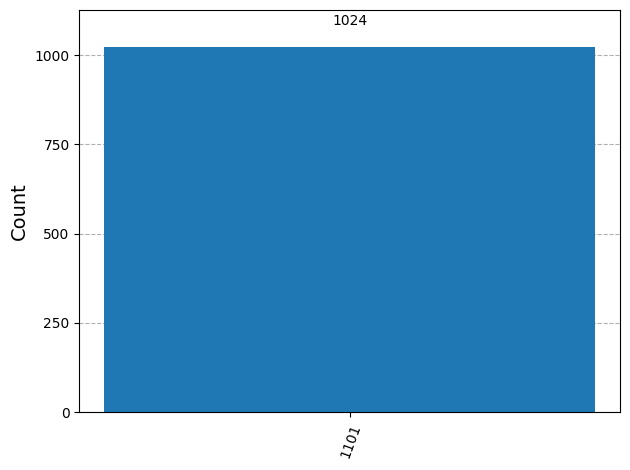

Counts: {'1101': 1024}
Most frequent measured bitstring (input register): 1101
Measured: 1101


In [16]:
# Task 2 display part (robust version)

for b in ["0", "1"]:
    print(f"\n--- s='1011', b={b} ---")
    qc_b = bernstein_vazirani_circuit_with_b("1011", b)

    # try pretty circuit first
    try:
        display(qc_b.draw(output="mpl", fold=-1))
    except Exception as e:
        # fallback to text circuit, so the notebook doesn't crash
        print("(fallback to text circuit)")
        print(qc_b.draw(output="text", fold=-1))
        # if you want to see why it failed:
        # print("drawer error:", e)

    counts_b, measured_b = run_bv(qc_b)
    print("Measured:", measured_b)


## 6. Task 4: Add Noise and analyze robustness
We now add a simple depolarizing noise model to see how the histogram spreads. In ideal case, only the correct bitstring appears. With noise, other strings appear.

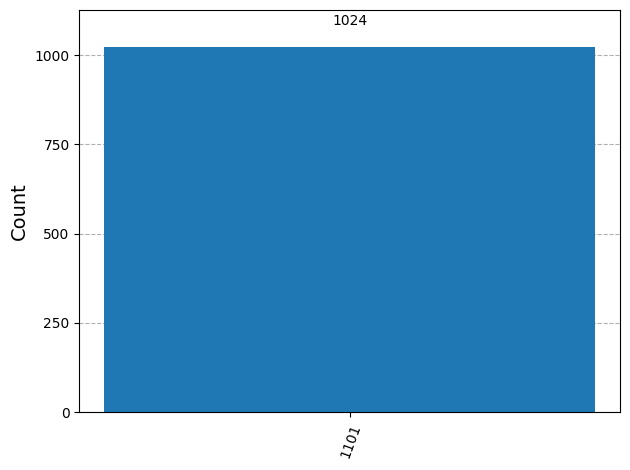

Counts: {'1101': 1024}
Most frequent measured bitstring (input register): 1101
Noisy counts: {'0000': 20, '1100': 19, '1000': 1, '1001': 22, '0001': 19, '0101': 39, '1101': 1928}


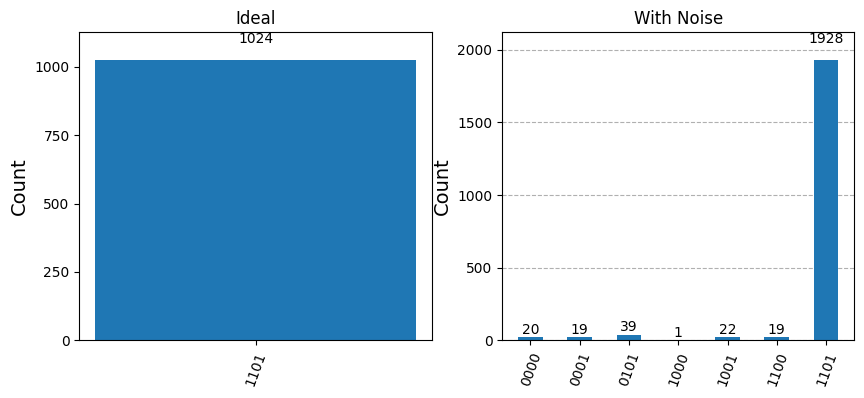

In [17]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

def build_noise_model():
    noise_model = NoiseModel()
    p1 = 0.005  # 0.5% for 1q gates
    p2 = 0.02   # 2% for 2q gates
    dep1 = depolarizing_error(p1, 1)
    dep2 = depolarizing_error(p2, 2)
    noise_model.add_all_qubit_quantum_error(dep1, ["h", "x"])
    noise_model.add_all_qubit_quantum_error(dep2, ["cx"])
    return noise_model

s = "1011"
qc_clean = bernstein_vazirani_circuit(s)

# ideal run
ideal_counts, _ = run_bv(qc_clean)

# noisy run
noise_model = build_noise_model()
sim_noisy = AerSimulator(noise_model=noise_model, basis_gates=noise_model.basis_gates)
tqc_noisy = transpile(qc_clean, sim_noisy)
res_noisy = sim_noisy.run(tqc_noisy, shots=2048).result()
noisy_counts = res_noisy.get_counts()

print('Noisy counts:', noisy_counts)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_histogram(ideal_counts, ax=axs[0])
axs[0].set_title('Ideal')
plot_histogram(noisy_counts, ax=axs[1])
axs[1].set_title('With Noise')
plt.show()


## 7. Summary
- BV finds `s` in one oracle call.
- Adding a constant bit `b` flips only the ancilla output, not the recovered string.
- Noise spreads the distribution; the correct string may still dominate if noise is small.
- Real hardware will look like the noisy case.
